In [2]:
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer

hi_text = "जीवन एक चॉकलेट बॉक्स की तरह है।"
chinese_text = "生活就像一盒巧克力。"

model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M")
tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M")

# translate Hindi to French
tokenizer.src_lang = "hi"
encoded_hi = tokenizer(hi_text, return_tensors="pt")
generated_tokens = model.generate(**encoded_hi, forced_bos_token_id=tokenizer.get_lang_id("fr"))
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
# => "La vie est comme une boîte de chocolat."

# translate Chinese to English
tokenizer.src_lang = "zh"
encoded_zh = tokenizer(chinese_text, return_tensors="pt")
generated_tokens = model.generate(**encoded_zh, forced_bos_token_id=tokenizer.get_lang_id("en"))
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
# => "Life is like a box of chocolate."


['Life is like a box of chocolate.']

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [3]:
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer

ko_text = "이것은 m2m모델로 만든 다국어 번역기입니다." #한국어로 바꾸기
chinese_text = "生活就像一盒巧克力。"

model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M")
tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M")


tokenizer.src_lang = "ko"
encoded_hi = tokenizer(ko_text, return_tensors="pt")
generated_tokens = model.generate(**encoded_hi, forced_bos_token_id=tokenizer.get_lang_id("en"))
result1=tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
print(result1)
# 한국어를 영어로


tokenizer.src_lang = "ko"
encoded_zh = tokenizer(chinese_text, return_tensors="pt")
generated_tokens = model.generate(**encoded_zh, forced_bos_token_id=tokenizer.get_lang_id("ja"))
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
# 한국어를 일본어로 바꿔줌


['This is a multi-language translator made with the m2m model.']


['人生は一箱のチョコレートのようだ。']

언어별 코드도 허깅페이스 홈페이지에서 확인가능
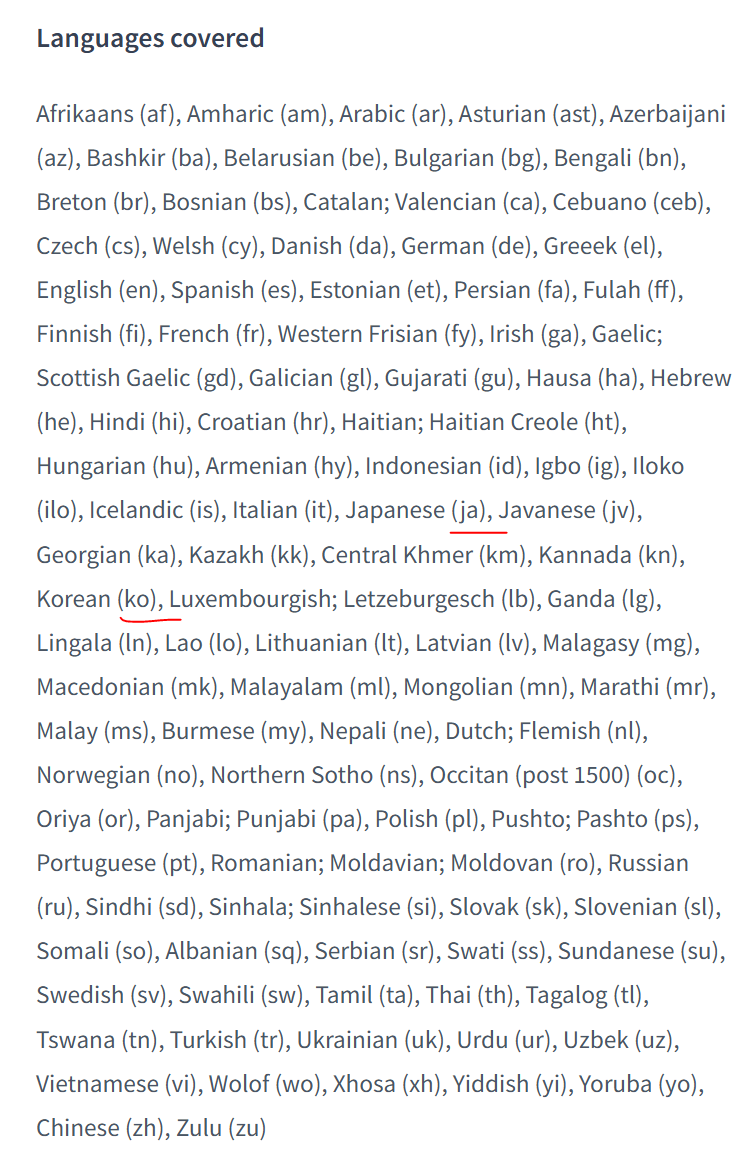

In [4]:
import gradio as gr
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer

# 모델과 토크나이저 로드
model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M")
tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M")

# 지원 언어 목록 (필요시 줄이거나 추가 가능)
LANGUAGES = {
    "한국어": "ko",
    "영어": "en",
    "일본어": "ja",
    "중국어": "zh",
    "프랑스어": "fr",
    "독일어": "de",
    "스페인어": "es",
    "아랍어": "ar",
    "히브리어": "he"
}

# 번역 함수 정의
def translate(text, src_lang, tgt_lang):
    if not text.strip():
        return "번역할 텍스트를 입력해주세요."
    tokenizer.src_lang = LANGUAGES[src_lang]
    encoded = tokenizer(text, return_tensors="pt")
    generated_tokens = model.generate(
        **encoded,
        forced_bos_token_id=tokenizer.get_lang_id(LANGUAGES[tgt_lang])
    )
    result = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    return result[0]

# Gradio 인터페이스 정의
with gr.Blocks() as demo:
    gr.Markdown("## 🌍 다국어 번역기 (M2M100 기반)")

    with gr.Row():
        with gr.Column():
            src_lang = gr.Dropdown(choices=list(LANGUAGES.keys()), value="한국어", label="원본 언어")
            tgt_lang = gr.Dropdown(choices=list(LANGUAGES.keys()), value="영어", label="번역 언어")
            input_text = gr.Textbox(label="입력 텍스트", lines=6, placeholder="여기에 번역할 문장을 입력하세요.")
            translate_btn = gr.Button("번역하기")
        with gr.Column():
            output_text = gr.Textbox(label="번역 결과", lines=6)

    translate_btn.click(fn=translate, inputs=[input_text, src_lang, tgt_lang], outputs=output_text)

# 실행
demo.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


gradio는 인공지능 모델을 간단하게 테스트해보는 공식 라이브러리
그래서 쉽게 만들수있다. 텍스트 번역서비스 이미지 분석을 한다던가 이런식으로 만들수있다.
허깅페이스는 모델종류가 정말 많음.

In [5]:
demo.close()



# 닫고
# 음성도 제공되는 번역기로 업그레이드해보기
# 허깅페이스 다시가서 microsoft/speecht5_tts 복붙하기

Closing server running on port: 7860


In [8]:
import subprocess
import importlib.util

# ✅ 필요한 라이브러리 자동 설치
for package in ["datasets", "soundfile"]:
    if importlib.util.find_spec(package) is None:
        subprocess.check_call(["pip", "install", package])

# ✅ 이후 모든 라이브러리 임포트
import gradio as gr
from transformers import (
    M2M100ForConditionalGeneration, M2M100Tokenizer,
    SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
)
from datasets import load_dataset
import torch
import soundfile as sf
import tempfile

# ✅ 모델 초기화
translation_model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M")
translation_tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M")

tts_processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
tts_model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
tts_vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

# ✅ Speaker embedding 고정값 불러오기
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embedding = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

# ✅ 지원 언어
LANGUAGES = {
    "한국어": "ko",
    "영어": "en",
    "일본어": "ja",
    "중국어": "zh",
    "프랑스어": "fr",
    "독일어": "de",
    "스페인어": "es",
    "아랍어": "ar",
    "히브리어": "he"
}

# ✅ 번역 + 음성 출력 함수
def translate_and_speak(text, src_lang_name, tgt_lang_name):
    if not text.strip():
        return "번역할 텍스트를 입력해주세요.", None

    src_lang = LANGUAGES[src_lang_name]
    tgt_lang = LANGUAGES[tgt_lang_name]

    # 번역
    translation_tokenizer.src_lang = src_lang
    encoded = translation_tokenizer(text, return_tensors="pt")
    generated_tokens = translation_model.generate(
        **encoded,
        forced_bos_token_id=translation_tokenizer.get_lang_id(tgt_lang)
    )
    translated_text = translation_tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]

    # TTS
    tts_inputs = tts_processor(text=translated_text, return_tensors="pt")
    speech = tts_model.generate_speech(tts_inputs["input_ids"], speaker_embedding, vocoder=tts_vocoder)

    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as fp:
        sf.write(fp.name, speech.numpy(), samplerate=16000)
        audio_path = fp.name

    return translated_text, audio_path

# ✅ Gradio 인터페이스 구성
with gr.Blocks() as demo:
    gr.Markdown("## 🌐 다국어 번역기 + 음성 출력 (M2M100 + SpeechT5)")

    with gr.Row():
        with gr.Column():
            src_lang = gr.Dropdown(label="원본 언어", choices=list(LANGUAGES.keys()), value="한국어")
            tgt_lang = gr.Dropdown(label="번역 언어", choices=list(LANGUAGES.keys()), value="영어")
            input_text = gr.Textbox(label="입력 텍스트", lines=5, placeholder="여기에 번역할 문장을 입력하세요.")
            translate_btn = gr.Button("번역 및 음성 출력")
        with gr.Column():
            output_text = gr.Textbox(label="번역 결과", lines=5)
            audio_output = gr.Audio(label="음성 재생", autoplay=True)

    translate_btn.click(fn=translate_and_speak,
                        inputs=[input_text, src_lang, tgt_lang],
                        outputs=[output_text, audio_output])

# ✅ 실행
demo.launch()


C:\Users\Admin\miniforge3\envs\ai_seving\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--microsoft--speecht5_tts. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\Admin\miniforge3\envs\ai_seving\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarn

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
